# Dimensionality reduction on rock, paper, scissors data


**Attribution**: This is an extended version of a notebook by:
> **Author**: Julien de la Bruère-Terreault <drgfreeman@tuta.io>  
> **Source**: https://github.com/DrGFreeman/rps-cv-data-science  
> **License**: MIT

In [1]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, fixed

import numpy as np
import pandas as pd

In [2]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 6.2 MB/s eta 0:00:00


In [3]:
!pip install git+https://github.com/ffund/rps-cv

  Cloning https://github.com/ffund/rps-cv to /tmp/pip-req-build-q5nck6g7
  Running command git clone --filter=blob:none --quiet https://github.com/ffund/rps-cv /tmp/pip-req-build-q5nck6g7
  Resolved https://github.com/ffund/rps-cv to commit 101c01d0d1e3511cfe18628c60c97af7752bd062
  Preparing metadata (setup.py) ... done
  Created wheel for rpscv: filename=rpscv-1.0.0-py3-none-any.whl size=12536 sha256=5eb7d71f77481c216eb55ed8db3eef6d434d47545d52286fb4fedf3b53fe4c49
  Stored in directory: /tmp/pip-ephem-wheel-cache-qiosj3tg/wheels/68/c4/51/5b179ad5d138f794260b0c9c4d514426ead30677fb8abc7e37
Successfully built rpscv


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from skopt import BayesSearchCV
from skopt.space import Real, Integer

from rpscv import imgproc

## Get data

In [5]:
!mkdir /content/rps-cv-data-science
%cd /content/rps-cv-data-science
!wget https://www.dropbox.com/s/sr1iui3zfdk0o53/rps-cv-images.zip
!unzip rps-cv-images.zip -d img/
!rm rps-cv-images.zip

/content/rps-cv-data-science
--2025-04-25 21:17:55--  https://www.dropbox.com/s/sr1iui3zfdk0o53/rps-cv-images.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/0xrefq5no4j4o2fih290a/rps-cv-images.zip?rlkey=iph41va0f6fh53mwzct5a0vg4 [following]
--2025-04-25 21:17:55--  https://www.dropbox.com/scl/fi/0xrefq5no4j4o2fih290a/rps-cv-images.zip?rlkey=iph41va0f6fh53mwzct5a0vg4
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc82a9cbead6731ea8db707f2d75.dl.dropboxusercontent.com/cd/0/inline/Coh49lDW_-AJpfieG662sUuseUnEHdhj2pSaQxBFd9g6ySU5cnhLuo5BND0F6eors8WOJpV1X3mUyUqZEGnLpHamRCZbeUYoQudLOax9wZk4G0DuO-PEkFv17I0pgNO7j4U/file# [following]
--2025-04-25 21:17:56--  https://uc82a9cbead6731ea8db707f2d75.dl.dropboxuse

The `generateGrayFeatures` function of the `rpscv.imgproc` module reads the images, removes the background, converts them to grayscale and rescales their values in the range of 0 (black) to 1 (white). The function outputs an array where each row represents the 60,000 pixel values of an image (200x300 pixels flattened) and a vector of label values in the form of integers (0 = *rock*, 1 = *paper*, 2 = *scissors*).

In [6]:
%cd /content/rps-cv-data-science

/content/rps-cv-data-science


In [7]:
X, y = imgproc.generateGrayFeatures()

Completed processing 2188 images


Let's check the shapes of the features X and labels y arrays.



In [8]:
X.shape, y.shape

((2188, 60000), (2188,))

There are 2188 images in the dataset. The X array stores the images, each represented as a vector of 60,000 pixel intensity values. These correspond to the 200 x 300 pixels of the original images in a flattened form.

We can pick any image from the X array, reshape it to its original dimensions and display it using the pyplot `imshow` function:

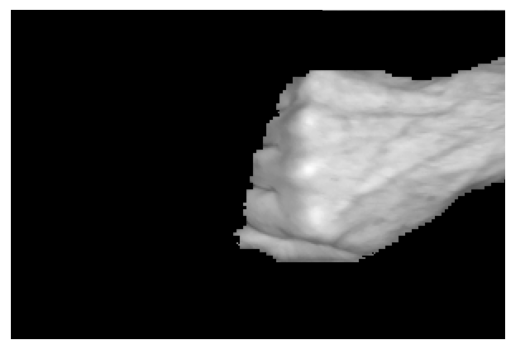

In [9]:
img = X[123].reshape((200, 300));
plt.imshow(img, cmap='gray');
plt.xticks([]);
plt.yticks([]);


The y array stores the labels corresponding to each image, encoded as integers.

In [10]:
np.unique(y, return_counts=True)

(array([0, 1, 2], dtype=int32), array([726, 712, 750]))

In [11]:
classes = np.array(['rock', 'paper', 'scissors'])

## Principal Component Analysis


To perform Principal Component Analysis, we use the PCA transformer from the Scikit-Learn decomposition module. For this demonstration, we choose to extract the 40 first principal components. When using PCA as a dimensionality reduction step in a machine learning pipeline, the number of principal components to extract is a parameter that can be tuned along with other model hyperparameters.



With the PCA transformer defined, we fit it to the array of image feature vectors X.



In [12]:
pca = PCA(n_components=40)
pca.fit(X)

PCA(n_components=40)

The principal components are orthogonal vectors, in the original feature space, where the first component represents the axis of maximum variance in the data, the second components represents the second axis of maximum variance, and so on, in order of decreasing value of explained variance.

The explained variance ratio (explained_variance / total_variance) of each component can be accessed from the explained_variance_ratio_ attribute of the PCA object.

Let's plot the explained variance ratio of each principal component.



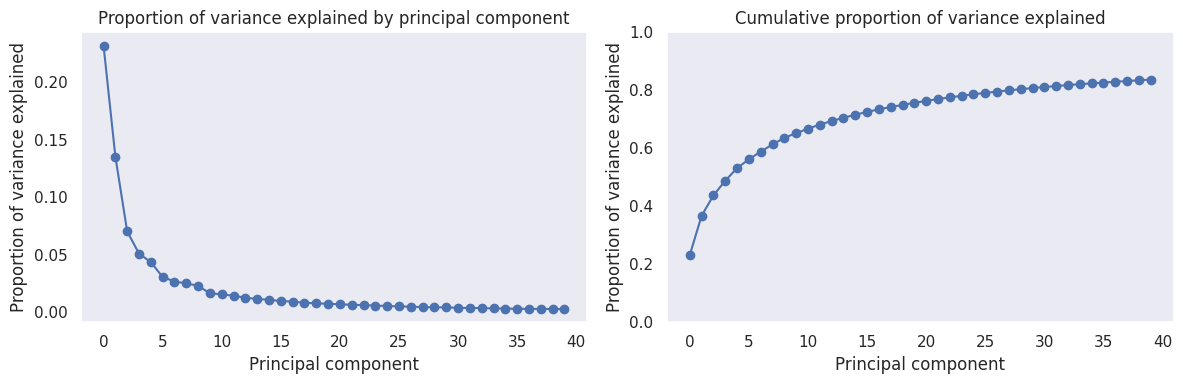

In [13]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(range(pca.n_components_), pca.explained_variance_ratio_)
plt.plot(range(pca.n_components_), pca.explained_variance_ratio_)
plt.xlabel('Principal component')
plt.ylabel('Proportion of variance explained')
plt.title('Proportion of variance explained by principal component')
plt.grid()
plt.subplot(1, 2, 2)
plt.scatter(range(pca.n_components_),pca.explained_variance_ratio_.cumsum())
plt.plot(range(pca.n_components_),pca.explained_variance_ratio_.cumsum())
plt.xlabel('Principal component')
plt.ylabel('Proportion of variance explained')
plt.title('Cumulative proportion of variance explained')
plt.ylim(0,1)
plt.grid()
plt.tight_layout()
plt.show()


We can see that the first 40 principal components explain more than 80% of the total variance and the first 5 components explain more than 50% of the total variance. As the number of components increases, the variance explained by each new component reduces.



### Principal component vectors


The calculated principal components are available as the components_ attribute of the fitted PCA object.

Let's look at the shape of the principal components array.



In [14]:
pca.components_.shape

(40, 60000)

As we specified, the principal components array contains 40 components, each represented by a vector of dimension 60,000.

The principal component vectors always have the same shape as the input features vector.

This means that we can visualize the principal components the same way as we visualize the input images. Let's look at the first principal component vector reshaped to dimensions 200 x 300.

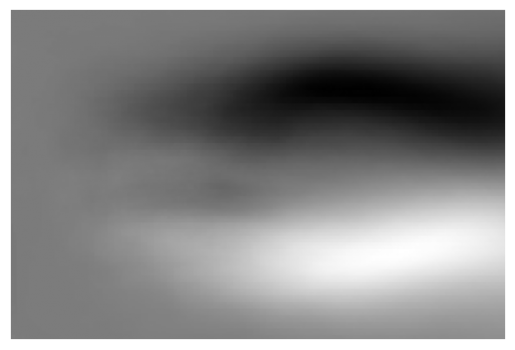

In [15]:
plt.imshow(pca.components_[0].reshape((200, 300)), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

Along with the principal component vectors, PCA also computes the mean of all the input images. This mean is stored as the mean_ attribute of the PCA object.



In [16]:
pca.mean_.shape

(60000,)

As expected, the mean has the same shape as the input features vector and the principal components vectors. We can therefore visualize the mean after reshaping it to the dimensions of the original images.



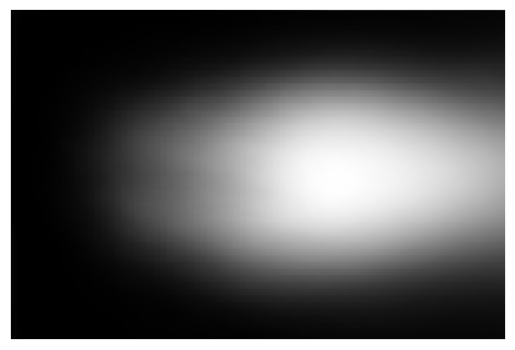

In [17]:
plt.imshow(pca.mean_.reshape((200, 300)), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

Let's now plot all the 40 principal component vectors as images. We include the explained variance ratio of each principal component in the title as reference.



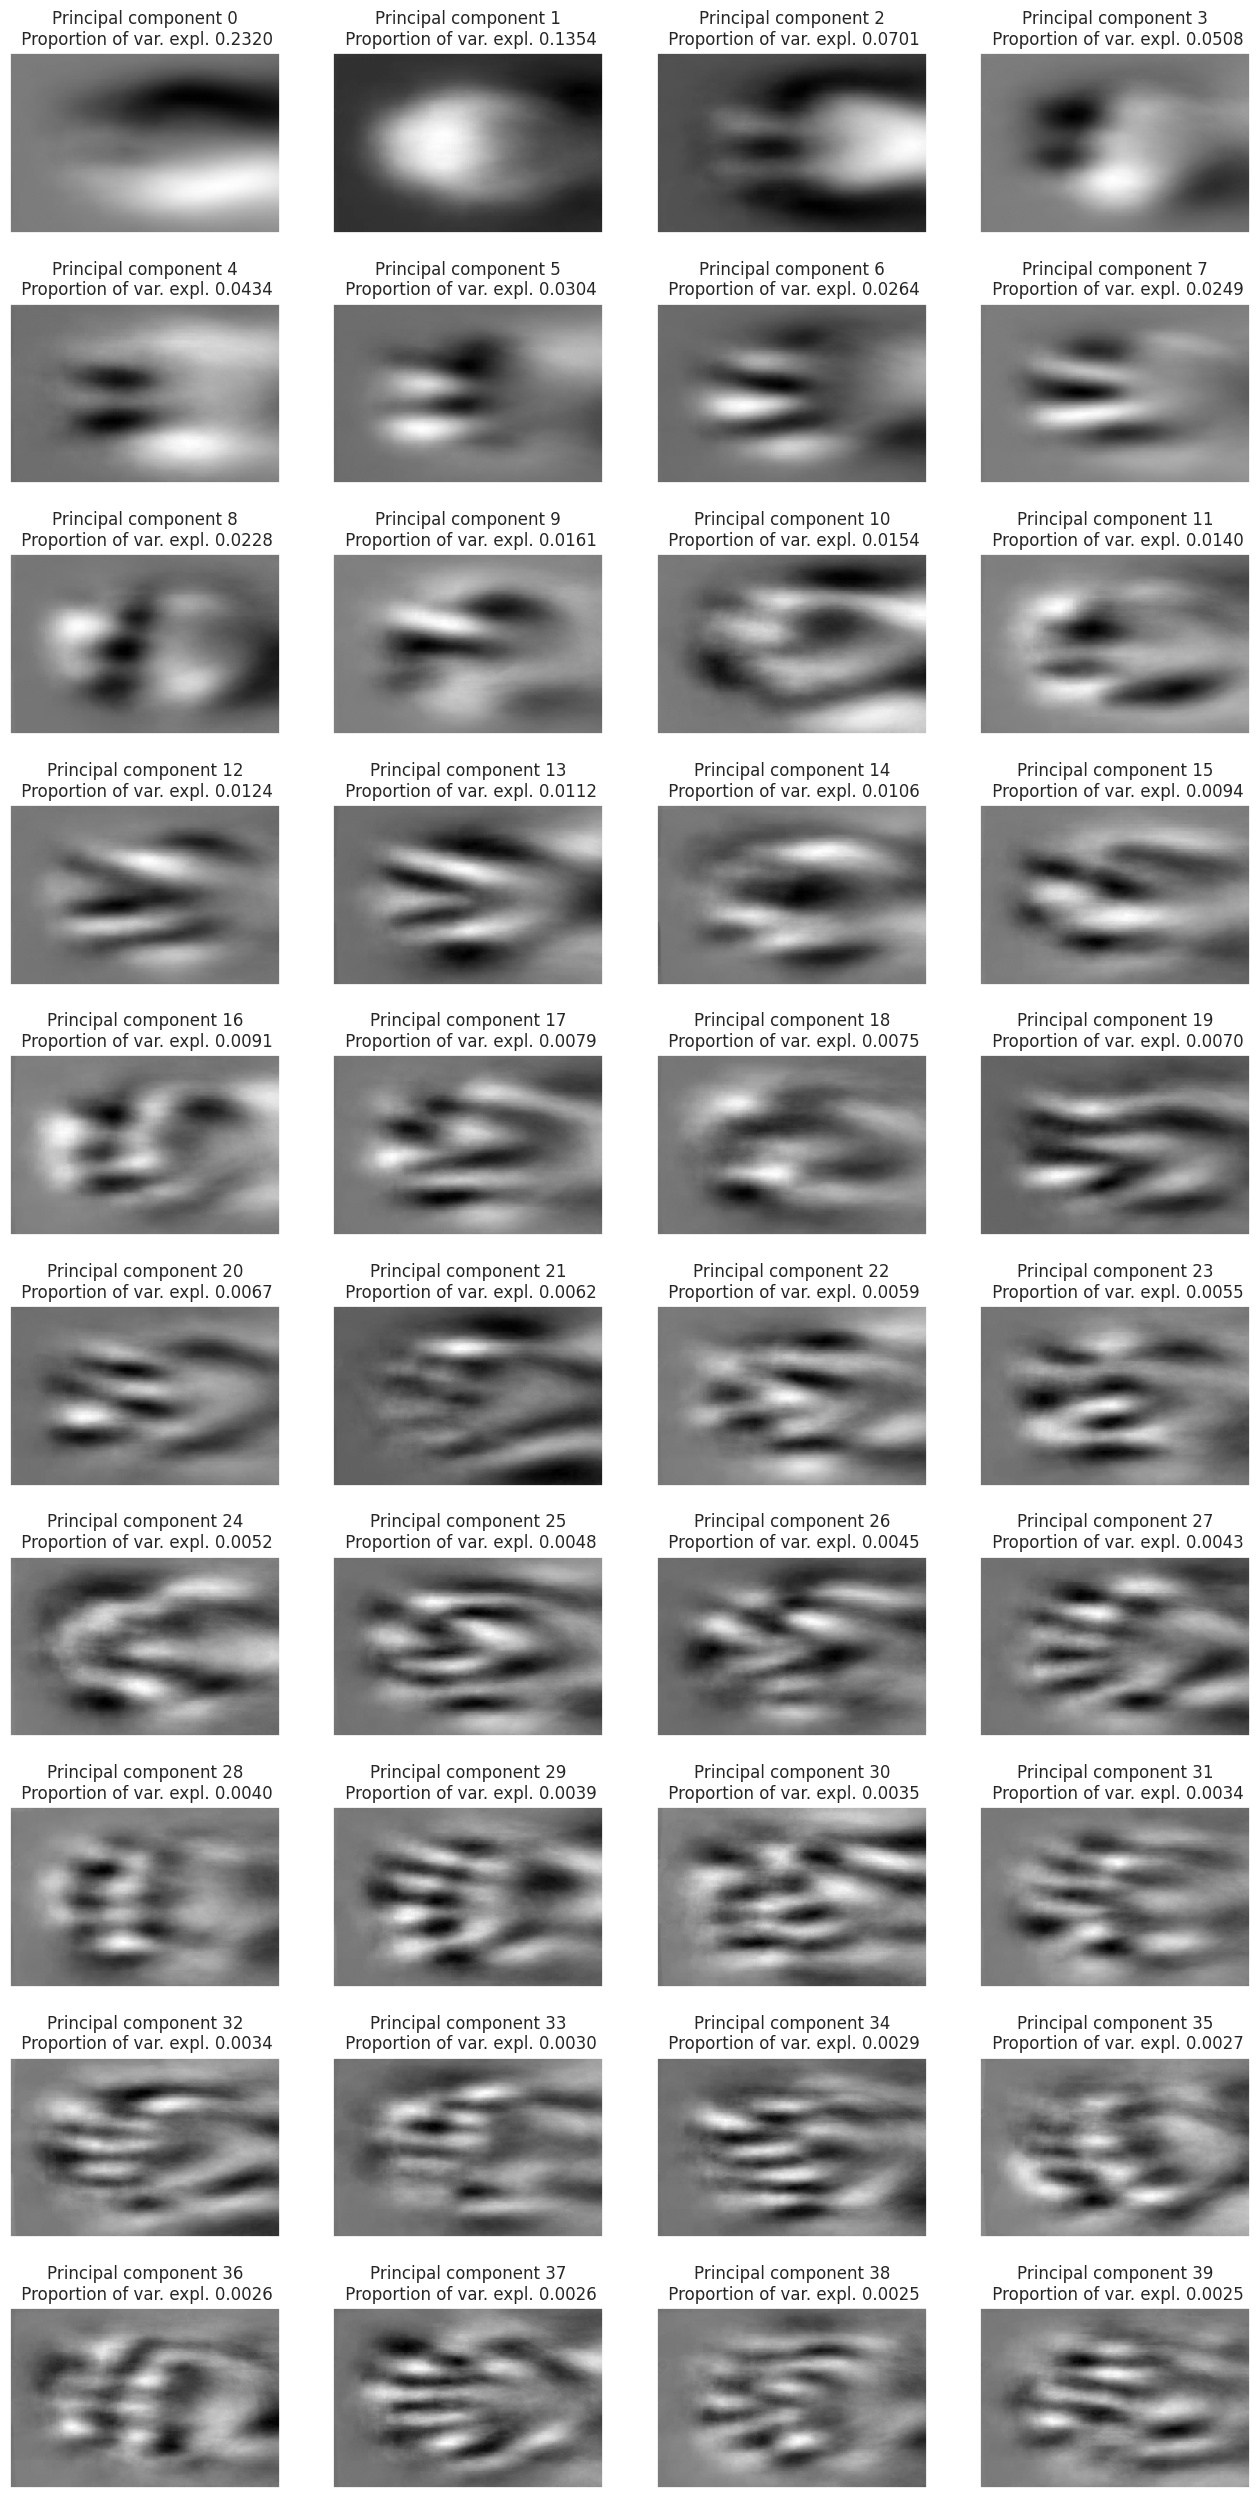

In [18]:
pc_imgs = pca.components_.reshape((len(pca.components_), 200, 300))

nb_col = 4
nb_row = pc_imgs.shape[0] // nb_col
plt.figure(figsize=(4 * nb_col, 3.2 * nb_row))
for i in range(nb_col * nb_row):
    plt.subplot(nb_row, nb_col, i+1)
    plt.imshow(pc_imgs[i], cmap='gray')
    plt.title("Principal component {:d}\n Proportion of var. expl. {:.4f}".format(i, pca.explained_variance_ratio_[i]))
    plt.xticks(())
    plt.yticks(())
plt.show()


The plots of the principal components vectors show that the first principal components encode relatively simple shapes. As the principal component number increases, the shapes represented by each principal component become more and more complex.



### Representation of images by their principal components


When using PCA as a means of dimensionality reduction, we want to encode each image in a vector of lower dimension than the original. This vector corresponds to factors by which we can multiply each of the principal component vectors to represent the original image. Let's go through this step by step.




In [19]:
X_pca = pca.transform(X)
X_pca.shape

(2188, 40)

Our transformed features array `X_pca` represents each image by a vector of dimension 40. We have therefore reduced our feature space from 60,000 dimensions to 40 dimensions, a reduction factor of 1500X !



We can pick any image from the transformed feature array and look at its content.



In [20]:
X_pca[123]

array([-16.329409  , -21.632277  ,   7.069298  ,  13.034777  ,
         6.6280746 ,   4.3790803 ,   1.4595904 ,   1.9767237 ,
        10.991631  ,  -3.8282104 ,   5.3373675 ,   3.502521  ,
        -3.128711  ,   4.396856  ,   0.9442625 ,   0.27115142,
        -0.04098034,   1.1241008 ,   0.49189794,   1.4425694 ,
         1.0721068 ,   3.0769534 ,  -1.8552722 ,   0.8826103 ,
        -4.0972123 ,  -0.3062942 ,   1.3661332 ,   1.7680618 ,
        -3.1305223 ,   1.3614335 ,  -0.19906181,  -0.64325124,
         1.9833261 ,  -3.6632276 ,  -1.3618078 ,  -0.58179367,
         0.9277253 ,  -0.10678651,  -3.1238918 ,  -3.4243693 ],
      dtype=float32)

We can use the 40 coefficients from this vector to multiply the 40 principal component vectors. This corresponds to the dot product of the transformed feature vector by the array of principal components. We can then add the PCA mean vector and obtain an image vector reconstructed from the principal components.



In [21]:
img_from_pcs = np.dot(X_pca[123], pca.components_) + pca.mean_

img_from_pcs.shape

(60000,)

We reshape this image vector to 200 x 300 pixels and display it alongside the original image.

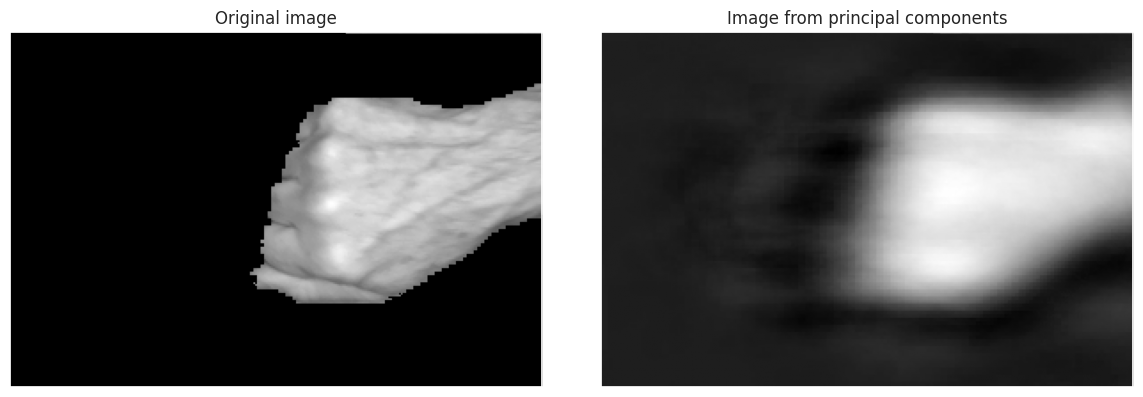

In [22]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(X[123].reshape((200, 300)), cmap='gray')
plt.title('Original image')
plt.xticks([])
plt.yticks([])
plt.subplot(1, 2, 2)
plt.imshow(img_from_pcs.reshape((200, 300)), cmap='gray')
plt.title('Image from principal components')
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

The `inverse_transform` method of the PCA class allows to perform this transformation from the principal component space to the original image feature space on the entire array of transformed images with ease.

In [23]:
X_from_pcs = pca.inverse_transform(X_pca)

X_from_pcs.shape

(2188, 60000)

We create a function to show the contribution of each of the principal component vectors in the progressive reconstruction of an image based on its features in the principal component space.



In [24]:
from ipywidgets import interactive
from ipywidgets import Layout
import ipywidgets as widgets

def progressive_plot(index, n_components):
    i = n_components - 1
    img = X[index]
    img_pc = X_pca[index]
    plt.figure(figsize=(12, 8))
    # Plot the original image
    plt.subplot(2, 2, 1)
    plt.imshow(img.reshape((200, 300)), cmap='gray')
    plt.title('Original image')
    plt.xticks([])
    plt.yticks([])
    # Plot the reconstructed image
    plt.subplot(2, 2, 2)
    if i == -1:
        plt.imshow(pca.mean_.reshape((200, 300)), cmap='gray')
        plt.title('Mean')
        plt.xticks([])
        plt.yticks([])
    else:
        plt.imshow((np.dot(img_pc[:i+1], pca.components_[:i+1])
                    + pca.mean_).reshape((200, 300)), cmap='gray')
        plt.title('Principal components 0 to {} + mean'.format(i))
        plt.xticks([])
        plt.yticks([])
    # Plot the bargraph
    plt.subplot(2, 2, 3)
    bars = plt.bar(range(pca.n_components_), img_pc, color='lightgray')
    if i >= 0:
        for j in range(n_components):
            bars[j].set_color('#6495ED')
        bars[i].set_color('r')
    plt.title('Image principal components magnitude')
    plt.xlabel('Principal component')
    plt.ylabel('Magnitude')
    # Plot the scaled principal component vector being added
    plt.subplot(2, 2, 4)
    if i == -1:
        plt.imshow(pca.mean_.reshape((200, 300)), cmap='gray')
        plt.title('Mean')
        plt.xticks([])
        plt.yticks([])
    else:
        plt.imshow((img_pc[i] * pca.components_[i]) .reshape((200, 300)), cmap='gray')
        plt.title('Principal component vector {} * {:.3g}'.format(i, img_pc[i]))
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()


The index slider allow selection of the index of the image to dislay. The n_components slider selects the number of principal components used for the reconstruction. Increasing this slider from 0 (only the mean) to the maximum number of principal components shows the contribution of each principal component in the reconstructed image.

The top left image shows the original image. The top right corner shows the image reconstructed with the selected number of principal components. The bottom left bargraph shows the magnitude of each principal component in the selected image in light gray. In red is the current principal component magnitude which is also represented in the bottom right image. In blue are the magnitudes of the lower principal components which, along with the current principal component, are used to reconstruct the image shown in the top right corner.



In [25]:
style = {'description_width': 'initial'}
layout = Layout(width="800px")
index = widgets.IntSlider(min=0, max=len(X) - 1, value=1502, style=style, layout=layout)
n_components = widgets.IntSlider(min=0, max=len(pca.components_), value=0, style=style, layout=layout)
interactive(progressive_plot, index=index, n_components=n_components)


interactive(children=(IntSlider(value=1502, description='index', layout=Layout(width='800px'), max=2187, style…

### Visualizing high dimensional data with PCA

We can also plot the rock, paper, scissors samples using the most important principal components:

In [26]:
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, fixed

def plot_3D(elev=90, azim=90, X=X_pca, y=y):

  fig = plt.figure(figsize=(10,10));
  ax = fig.add_subplot(111, projection='3d');
  ax.view_init(elev=elev, azim=azim)

  ax.scatter3D(X[:,0], X[:,1], X[:,2], c=y, s=20, cmap='viridis');

  ax.set_xlabel('PC 0');
  ax.set_ylabel('PC 1');
  ax.set_zlabel('PC 2');

  plt.show();

In [27]:
interact(plot_3D, X=fixed(X_pca), y=fixed(y));

interactive(children=(IntSlider(value=90, description='elev', max=270, min=-90), IntSlider(value=90, descripti…

## Classification with supervised learning after PCA transformation

We can use the reduced data as input to a supervised classifier, and use it to classify the images as rock, paper, and scissors.

First, we split the data into a training and test set.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25,
                                                    stratify=y, random_state=42)

### Model definition
The model consists of a Principal Component Analysis (PCA) transformer followed by a Support Vector Machine classifier.

The SVM classifier will take the transformed features from the PCA, along with the image labels, to fit a classification model and perform the predictions.

The PCA transformer and SVM classifier are assembled into a scikit-Learn `Pipeline` object. This will allow us to perform cross-validation on the training data during the model hyperparameter tuning.

The `rbf` kernel is selected for the support vector classifier as it allows more complex, non-linear decision boundaries.

In [29]:
pipeline = Pipeline([('pca', PCA()),
                     ('clf', SVC(kernel='rbf'))])

Next, we define the range of the model hyperparameters into which to perform the search. We will be using the `BayesSearchCV` class of the scikit-optimize package. (More on that [here](https://thuijskens.github.io/2016/12/29/bayesian-optimisation/)!)

We define the range of principal components (`n_components`) for the `PCA` transformer as integers between 20 and 100.

We define the `gamma` and `C` parameters of the `SVC` as reals with the ranges .0001-.01 and 1-3000 respectively.

In [30]:
opt_params = {'pca__n_components': Integer(20, 100),
              'clf__gamma': Real(.0001, .01, prior='log-uniform'),
              'clf__C': Real(1, 3000, prior='log-uniform')}

We define the model as the `BayesSearchCV` cross-validation object, passing the `pipeline` object defined previously as estimator. We pass the hyperparameter dictionary as search space and specify the number of iterations for the hyperparameter search.

We use 5 fold cross-validation. The use of `StratifiedKFold` ensures that each class will be equally represented in each of the cross-validation folds.

In [31]:
model = BayesSearchCV(pipeline,
                      search_spaces=opt_params,
                      n_iter=20,
                      cv=StratifiedKFold(n_splits=5),
                      scoring='accuracy',
                      return_train_score=True,
                      verbose=100)

### Fit model and evaluate on training set

With the model defined, we call the `fit` method on the model which performs the hyperparameter optimization.

In [32]:
%%time
model.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START clf__C=1.9145768170620312, clf__gamma=0.008147425738600523, pca__n_components=28
[CV 1/5; 1/1] END clf__C=1.9145768170620312, clf__gamma=0.008147425738600523, pca__n_components=28;, score=(train=1.000, test=0.857) total time=   8.2s
[CV 2/5; 1/1] START clf__C=1.9145768170620312, clf__gamma=0.008147425738600523, pca__n_components=28
[CV 2/5; 1/1] END clf__C=1.9145768170620312, clf__gamma=0.008147425738600523, pca__n_components=28;, score=(train=1.000, test=0.854) total time=   7.0s
[CV 3/5; 1/1] START clf__C=1.9145768170620312, clf__gamma=0.008147425738600523, pca__n_components=28
[CV 3/5; 1/1] END clf__C=1.9145768170620312, clf__gamma=0.008147425738600523, pca__n_components=28;, score=(train=1.000, test=0.863) total time=   3.9s
[CV 4/5; 1/1] START clf__C=1.9145768170620312, clf__gamma=0.008147425738600523, pca__n_components=28
[CV 4/5; 1/1] END clf__C=1.9145768170620312, clf__gamma=0.008147425738600523, pca

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
              estimator=Pipeline(steps=[('pca', PCA()), ('clf', SVC())]),
              n_iter=20, return_train_score=True, scoring='accuracy',
              search_spaces={'clf__C': Real(low=1, high=3000, prior='log-uniform', transform='normalize'),
                             'clf__gamma': Real(low=0.0001, high=0.01, prior='log-uniform', transform='normalize'),
                             'pca__n_components': Integer(low=20, high=100, prior='uniform', transform='normalize')},
              verbose=100)

We print the best set of hyperparamters found during the optimization as well as the model score obtained on the training set with the k-fold cross-validation.

In [33]:
model.best_params_

OrderedDict([('clf__C', 8.694738267876797),
             ('clf__gamma', 0.0005651525305268393),
             ('pca__n_components', 37)])

In [34]:
model.best_score_

0.9847690710949661

### Model evaluation on test set

By default, the `BayesSearchCV` object, as well as the scikit-learn `GridSearchCV` of `RandomSearchCV` objects, retrain the model, with the best hyperparameters, on the full training set at the end of the hyperparameter optimization. We therefore don't need to perform this test manually prior to evaluating the model on the test set.

We use the model `score` method to evaluate the model score on the test set which it has never seen.

In [35]:
model.score(X_test, y_test)

0.9725776965265083

The model achieves a very good score for such a small dataset with no data augmentation used. There is also only a small loss of performance compared to the model score on the training set, which indicates that the model is probably not overfitting the data.

To further evaluate the model performance, we use the model's `predict` method to predict the labels of the test set.

In [36]:
y_pred = model.predict(X_test)

Finally, we print the confusion matrix of predictions on the test set, which helps us understand where the models predictions are wrong.

In [37]:
conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred))
conf_matrix.index = pd.MultiIndex.from_tuples([('true label', label) for label in classes])
conf_matrix.columns = pd.MultiIndex.from_tuples([('predicted label', label) for label in classes])
conf_matrix

predicted label               
                               rock paper scissors
true label rock                 181     1        0
           paper                  6   171        1
           scissors               1     6      180

## Dimensionality reduction with neural networks

The approach we took is actually very similar in some ways to what a neural network does: it learns a representation of the data (and if the learned representation is of lower dimension than the input, it's doing dimensionality reduction). Then it uses that learned representation as input to a classifier.

We could also use a neural network (without the classification "head") to do the unsupervised dimensionality reduction! The network will be trained to learn an approximation of the input image as the output.

**Change the runtime to GPU to run the rest of this notebook.**

In [38]:
import tensorflow_datasets as tfds
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

In [39]:
(ds_train, ds_test), ds_info = tfds.load(
    'rock_paper_scissors',
    split=['train', 'test'],
    shuffle_files=False,
    with_info=True,
    as_supervised=False
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2520 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/incomplete.HZEI3A_3.0.0/rock_paper_scissors-train.tfre…

Generating test examples...:   0%|          | 0/372 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/incomplete.HZEI3A_3.0.0/rock_paper_scissors-test.tfrec…

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


In [40]:
INPUT_IMG_SIZE = 224
INPUT_IMG_SHAPE = (224, 224, 3)

In [41]:
def preprocess_image(sample):
    sample['image'] = tf.cast(sample['image'], tf.float32)
    sample['image'] = tf.image.resize(sample['image'], [INPUT_IMG_SIZE, INPUT_IMG_SIZE])
    return sample['image']

In [42]:
ds_train = ds_train.map(preprocess_image).map(lambda x : (x, x)).batch(32).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess_image).map(lambda x : (x, x)).batch(32).prefetch(tf.data.AUTOTUNE)

In [43]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Activation, Rescaling, Resizing
from keras.models import Model, Sequential
from keras import backend as K

In [44]:
# Define the model
encoder = Sequential()

encoder.add(Input(shape=(224,224,3)))
encoder.add(Rescaling(scale=1./127.5, offset=-1))

encoder.add(Conv2D(16, (3, 3), padding='same'))
encoder.add(Activation('relu'))
encoder.add(MaxPooling2D(pool_size=(2,2), padding='same'))

encoder.add(Conv2D(8,(3, 3), padding='same'))
encoder.add(Activation('relu'))
encoder.add(MaxPooling2D(pool_size=(2,2), padding='same'))

encoder.add(Conv2D(1,(3, 3), padding='same'))
encoder.add(Activation('relu'))
encoder.add(MaxPooling2D(pool_size=(2,2), padding='same'))

encoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 224, 224, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 8)         │           1,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 112, 112, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 1)           │              73 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 56, 56, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,681 (6.57 KB)

 Trainable params: 1,681 (6.57 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
decoder = Sequential()

decoder.add(Input(shape=(28,28,1)))
decoder.add(Conv2D(1, (3, 3), padding='same'))
decoder.add(Activation('relu'))
decoder.add(UpSampling2D((2, 2)))

decoder.add(Conv2D(8,(3, 3), padding='same'))
decoder.add(Activation('relu'))
decoder.add(UpSampling2D((2, 2)))

decoder.add(Conv2D(16,(3, 3), padding='same'))
decoder.add(Activation('relu'))
decoder.add(UpSampling2D((2, 2)))

decoder.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 1)           │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 56, 56, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 8)           │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 56, 56, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 112, 112, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 112, 112, 16)        │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 224, 224, 16)        │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,258 (4.91 KB)

 Trainable params: 1,258 (4.91 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
model = Sequential()
model.add(encoder)
model.add(decoder)
model.add(Conv2D(3,(3, 3), padding='same'))
model.add(Activation('linear'))

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 28, 28, 1)           │           1,681 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 224, 224, 16)        │           1,258 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 224, 224, 3)         │             435 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 224, 224, 3)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,374 (13.18 KB)

 Trainable params: 3,374 (13.18 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [48]:
hist = model.fit(ds_train,
                epochs=30,
                shuffle=False,
                validation_data=ds_test)

Epoch 1/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 149ms/step - loss: 44280.0938 - val_loss: 3292.1694
Epoch 2/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 3347.7004 - val_loss: 2640.1199
Epoch 3/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 2609.2974 - val_loss: 1786.6482
Epoch 4/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 1912.7556 - val_loss: 1395.5577
Epoch 5/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 1461.7158 - val_loss: 1159.3214
Epoch 6/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 1184.3236 - val_loss: 1026.5061
Epoch 7/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 1046.4886 - val_loss: 933.2957
Epoch 8/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 963.0856 - val_loss: 843.6198
Epoch 9/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 904.1597 - val_loss: 724.8649
Epoch 10/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 851.6370 - val_loss: 643.8057
Epoch 11/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 797.5900 - val_loss: 591.2533
Epo

When we train the model, we pass the images as both the features *and* the labels!

In [49]:
decoded_imgs = model.predict(ds_test)
encoded_imgs = encoder.predict(ds_test)
encoded_imgs.shape

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


(372, 28, 28, 1)

In [50]:
X_test_nn = np.asarray(list(ds_test.unbatch().map(lambda x, y: x)))
X_test_nn.shape

(372, 224, 224, 3)

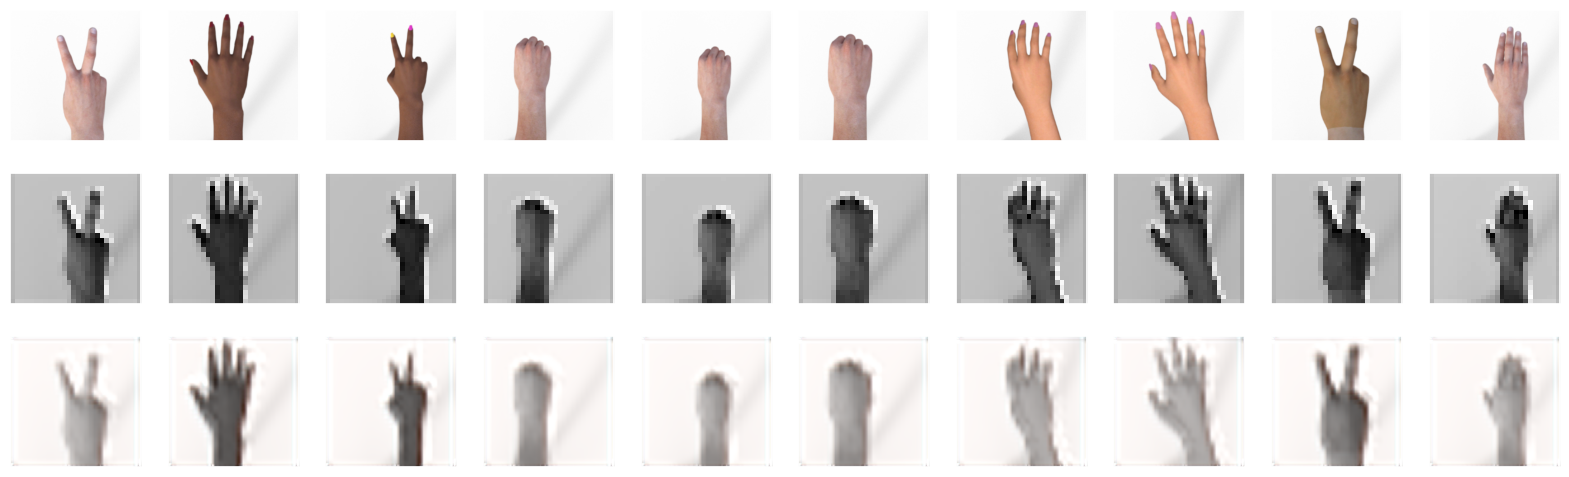

In [55]:
n = 10
plt.figure(figsize=(20, 6))

for i in range(n):

    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(X_test_nn[i]/255.0)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display encoded image via neural autoencoder
    ax = plt.subplot(3, n, i + n + 1)
    plt.imshow(encoded_imgs[i, :, :, 0].reshape(encoded_imgs.shape[1], encoded_imgs.shape[2]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction via neural autoencoder
    ax = plt.subplot(3, n, i + 2*n + 1)
    plt.imshow(decoded_imgs[i].reshape(224, 224, 3)/255.0)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()
